In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

dataset_code = 'A'
model_name = 'inception_v3'
data_saved_dir = r'D:\My Code\Classification\pickle_data'
train_data_path = os.path.join(data_saved_dir, f'{dataset_code}_training.pkl')
train_images, train_labels = load_pickle(train_data_path)

val_data_path = os.path.join(data_saved_dir, 'validation_data.pkl')
val_images, val_labels = load_pickle(val_data_path)

In [3]:
IncV3 = InceptionV3(include_top = False, weights = "imagenet",input_shape = (256,256,3))

model = Sequential()
model.add(IncV3)
    
for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units = 2048, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = "sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 2048)              150996992 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 172,801,825
Trainable params: 150,999,041
Non-trainable params: 21,802,784
_________________________________________________________________


In [4]:
history = model.fit(train_images, train_labels, epochs = 50, batch_size = 32, validation_data = (val_images, val_labels))

Epoch 1/50
35/35 [==============================] - 13s 190ms/step - loss: 14.4206 - accuracy: 0.7867 - val_loss: 9.3649 - val_accuracy: 0.7448
Epoch 2/50
35/35 [==============================] - 3s 86ms/step - loss: 3.0276 - accuracy: 0.9023 - val_loss: 1.9353 - val_accuracy: 0.9205
Epoch 3/50
35/35 [==============================] - 3s 87ms/step - loss: 1.0221 - accuracy: 0.9507 - val_loss: 1.8375 - val_accuracy: 0.9289
Epoch 4/50
35/35 [==============================] - 3s 88ms/step - loss: 0.5158 - accuracy: 0.9659 - val_loss: 1.4575 - val_accuracy: 0.9331
Epoch 5/50
35/35 [==============================] - 3s 87ms/step - loss: 0.4065 - accuracy: 0.9731 - val_loss: 1.3380 - val_accuracy: 0.9414
Epoch 6/50
35/35 [==============================] - 3s 86ms/step - loss: 0.1871 - accuracy: 0.9848 - val_loss: 1.4804 - val_accuracy: 0.9289
Epoch 7/50
35/35 [==============================] - 3s 87ms/step - loss: 0.2065 - accuracy: 0.9821 - val_loss: 1.3114 - val_accuracy: 0.9456
Epoch 8/50

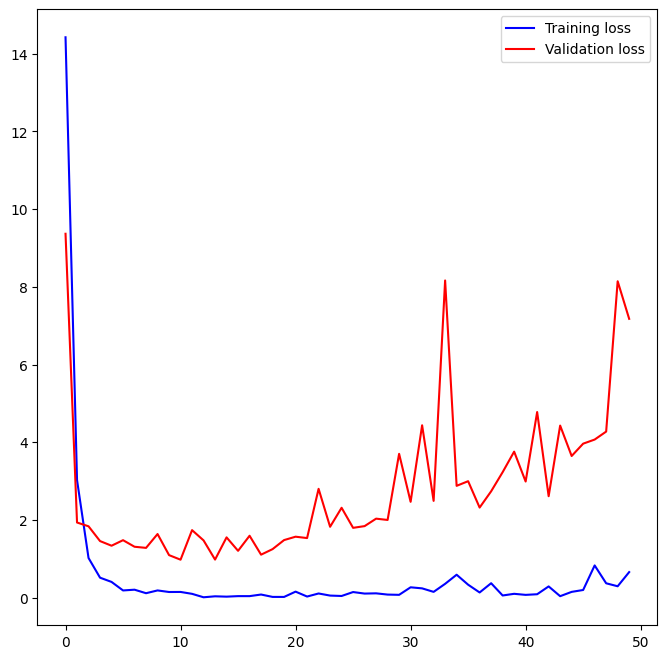

<Figure size 640x480 with 0 Axes>

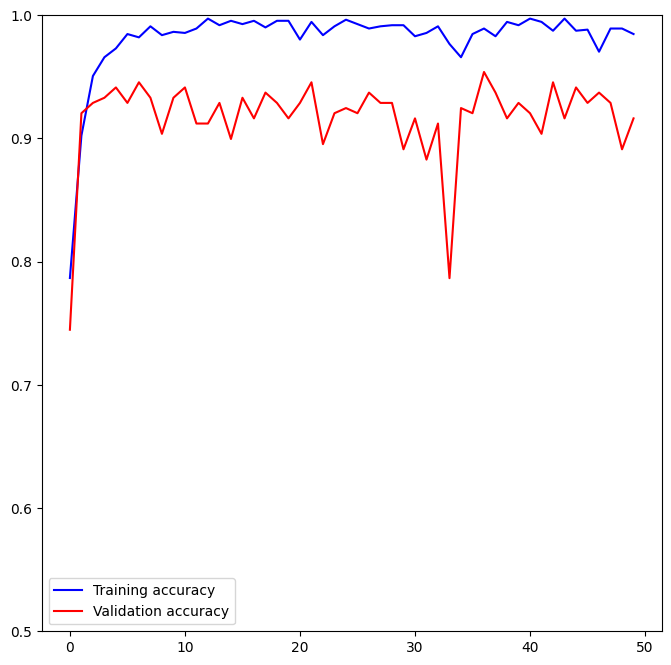

In [5]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

8/8 [==============================] - 1s 86ms/step


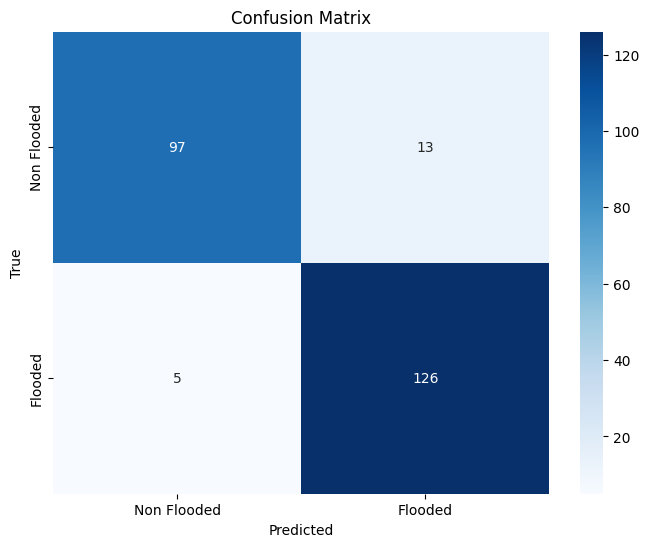

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92       110
           1       0.91      0.96      0.93       131

    accuracy                           0.93       241
   macro avg       0.93      0.92      0.92       241
weighted avg       0.93      0.93      0.93       241



In [8]:
test_data_path = os.path.join(data_saved_dir, 'test_data.pkl')
test_images, test_labels = load_pickle(test_data_path)

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [9]:
model_saved = r'D:\My Code\Classification\models'
model.save(os.path.join(model_saved, f'{dataset_code}_{model_name} (256X256).h5'))